# Random Forest Analysis: Rotten Tomatoes Score vs Critic Review Positivity

This notebook tests whether a movie’s Rotten Tomatoes score is associated with the positivity of individual critic reviews.

Steps:
1. Load movie + review datasets
2. Compute TextBlob polarity from `reviewText`
3. Define a binary positivity label from polarity
4. Detect a Rotten Tomatoes score column automatically
5. Train/evaluate a **RandomForestClassifier** to predict positivity from the RT score
6. Save outputs (report + plots) into `output/`

⚠️ Interpretation note: This is **correlational**. Rotten Tomatoes scores are derived from critic reviews, so reverse causality / simultaneity is likely.


In [1]:
# Install if needed (run once):
# !pip install pandas numpy scikit-learn matplotlib textblob

import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, roc_auc_score, RocCurveDisplay,
    confusion_matrix, ConfusionMatrixDisplay
)


In [2]:
# -----------------------------
# Output folder helpers
# -----------------------------
OUTPUT_DIR = Path("../output")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

def safe_filename(name: str) -> str:
    # Windows-illegal chars: < > : " / \ | ? *
    name = re.sub(r'[<>:"/\\|?*]', '', name)
    return name.replace(" ", "_")

print("Output folder:", OUTPUT_DIR.resolve())


Output folder: C:\Users\chank\github\DataScienceProject1\output


In [3]:
# -----------------------------
# Load data
# -----------------------------
# If your files are elsewhere, change these paths:
movies_path = Path("../data/rotten_tomatoes_movies.csv")
reviews_path = Path("../data/rotten_tomatoes_movie_reviews.csv")

movies = pd.read_csv(movies_path)
reviews = pd.read_csv(reviews_path)

print("Movies:", movies.shape)
print("Reviews:", reviews.shape)

df = reviews.merge(movies, on="id", how="inner")
print("Merged:", df.shape)

df.head()


Movies: (143258, 16)
Reviews: (1444963, 11)
Merged: (1469543, 26)


,id,reviewId,creationDate,criticName,isTopCritic,originalScore,reviewState,publicatioName,reviewText,scoreSentiment,...,releaseDateTheaters,releaseDateStreaming,runtimeMinutes,genre,originalLanguage,director,writer,boxOffice,distributor,soundMix
0,beavers,1145982,2003-05-23,Ivan M. Lincoln,False,3.5/4,fresh,Deseret News (Salt Lake City),Timed to be just long enough for most youngste...,POSITIVE,...,NaN,2011-06-21,30.0,Documentary,English,Stephen Low,NaN,NaN,NaN,NaN
1,blood_mask,1636744,2007-06-02,The Foywonder,False,1/5,rotten,Dread Central,It doesn't matter if a movie costs 300 million...,NEGATIVE,...,NaN,NaN,NaN,NaN,NaN,Unknown Director,NaN,NaN,NaN,NaN
2,city_hunter_shinjuku_private_eyes,2590987,2019-05-28,Reuben Baron,False,NaN,fresh,CBR,The choreography is so precise and lifelike at...,POSITIVE,...,NaN,NaN,NaN,NaN,NaN,Kenji Kodama,NaN,NaN,NaN,NaN
3,city_hunter_shinjuku_private_eyes,2558908,2019-02-14,Matt Schley,False,2.5/5,rotten,Japan Times,The film's out-of-touch attempts at humor may ...,NEGATIVE,...,NaN,NaN,NaN,NaN,NaN,Kenji Kodama,NaN,NaN,NaN,NaN
4,dangerous_men_2015,2504681,2018-08-29,Pat Padua,False,NaN,fresh,DCist,Its clumsy determination is endearing and some...,POSITIVE,...,NaN,NaN,NaN,NaN,NaN,Unknown Director,NaN,NaN,NaN,NaN


## Compute TextBlob sentiment polarity and define positivity label

In [4]:
# Polarity in [-1, 1]
# NOTE: This can take time on a large dataset. If it’s slow, consider sampling or caching.
df["polarity"] = df["reviewText"].fillna("").astype(str).apply(
    lambda t: TextBlob(t).sentiment.polarity
)

# Positivity label (neutral band around 0 to reduce ambiguity)
NEUTRAL_BAND = 0.05
df["positive_review"] = (df["polarity"] > NEUTRAL_BAND).astype(int)

df[["polarity", "positive_review"]].describe()


,polarity,positive_review
count,1.469543e+06,1.469543e+06
mean,1.279688e-01,5.663999e-01
std,2.716171e-01,4.955716e-01
min,-1.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,1.000000e-01,1.000000e+00
75%,2.916667e-01,1.000000e+00
max,1.000000e+00,1.000000e+00


## Detect Rotten Tomatoes score column
We try to automatically find a score column. If this fails, set `rt_score` manually.

In [5]:
# Show likely candidates
candidates = [c for c in df.columns if ("tomato" in c.lower() or "tomat" in c.lower() or "score" in c.lower())]
print("Possible score-related columns:")
print(candidates)


Possible score-related columns:
['originalScore', 'scoreSentiment', 'audienceScore', 'tomatoMeter']


In [7]:
for col in df.columns:
    print(col)

id
reviewId
creationDate
criticName
isTopCritic
originalScore
reviewState
publicatioName
reviewText
scoreSentiment
reviewUrl
title
audienceScore
tomatoMeter
rating
ratingContents
releaseDateTheaters
releaseDateStreaming
runtimeMinutes
genre
originalLanguage
director
writer
boxOffice
distributor
soundMix
polarity
positive_review


In [8]:
# Heuristic detection: prefer columns containing 'tomato' and 'score'
rt_score = "tomatoMeter"

# preferred = [c for c in df.columns if ("tomato" in c.lower() or "tomat" in c.lower()) and "score" in c.lower()]
# if preferred:
#     rt_score = preferred[0]
# else:
#     # fallback: common names people see in RT datasets
#     common = ["tomatometerScore", "tomatoScore", "tomatometer_score", "tomatometer"]
#     for c in common:
#         if c in df.columns:
#             rt_score = c
#             break

# if rt_score is None:
#     raise ValueError("Could not auto-detect a Rotten Tomatoes score column. Please set rt_score manually.")

print("Using RT score column:", rt_score)

# Ensure numeric
df[rt_score] = pd.to_numeric(df[rt_score], errors="coerce")
df[[rt_score]].describe()


Using RT score column: tomatoMeter


,tomatoMeter
count,1.398270e+06
mean,6.692012e+01
std,2.607975e+01
min,0.000000e+00
25%,4.800000e+01
50%,7.400000e+01
75%,8.900000e+01
max,1.000000e+02


## Visualize RT score vs polarity

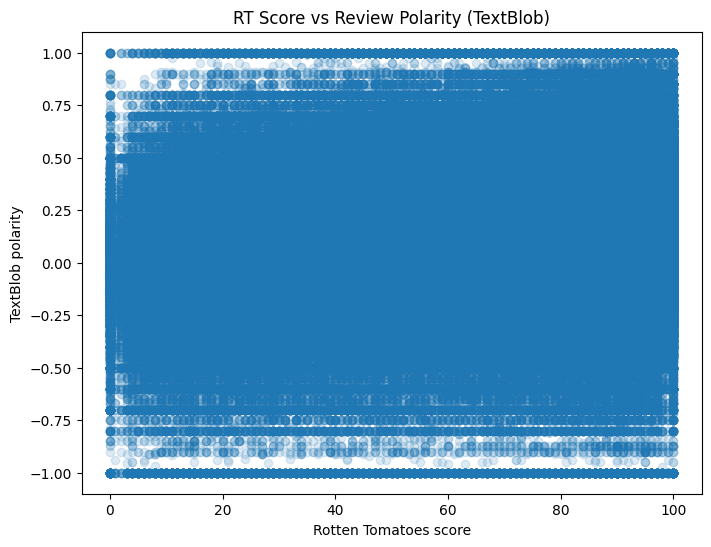

Saved: C:\Users\chank\github\DataScienceProject1\output\rt_score_vs_textblob_polarity.png


In [9]:
plot_path = OUTPUT_DIR / safe_filename("rt_score_vs_textblob_polarity.png")

plt.figure(figsize=(8,6))
plt.scatter(df[rt_score], df["polarity"], alpha=0.15)
plt.xlabel("Rotten Tomatoes score")
plt.ylabel("TextBlob polarity")
plt.title("RT Score vs Review Polarity (TextBlob)")
plt.savefig(plot_path, bbox_inches="tight")
plt.show()

print("Saved:", plot_path.resolve())


## Random Forest: Predict positivity from RT score
This is a **predictive** test (not p-values). We evaluate with AUC and a classification report.

In [10]:
analysis_df = df.dropna(subset=[rt_score]).copy()

X = analysis_df[[rt_score]]
y = analysis_df["positive_review"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

report = classification_report(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print(report)
print("ROC AUC:", auc)


              precision    recall  f1-score   support

           0       0.51      0.45      0.48    120816
           1       0.62      0.68      0.65    158838

    accuracy                           0.58    279654
   macro avg       0.57      0.56      0.56    279654
weighted avg       0.57      0.58      0.57    279654

ROC AUC: 0.5848264603770451


In [11]:
# Save report
report_path = OUTPUT_DIR / "random_forest_report.txt"
report_path.write_text(report + f"\nROC AUC: {auc:.4f}\n", encoding="utf-8")
print("Saved:", report_path.resolve())


Saved: C:\Users\chank\github\DataScienceProject1\output\random_forest_report.txt


<Figure size 640x480 with 0 Axes>

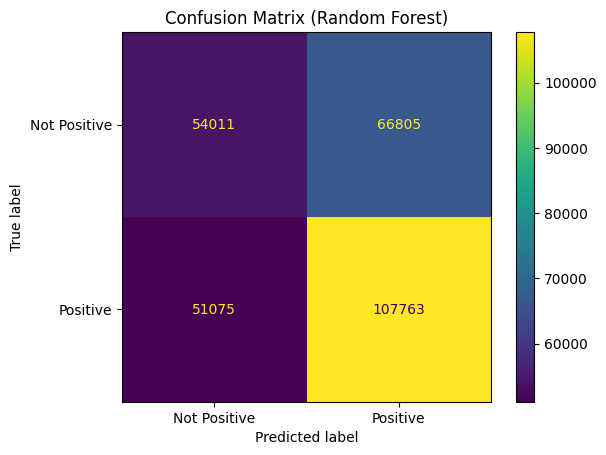

Saved: C:\Users\chank\github\DataScienceProject1\output\confusion_matrix_random_forest.png


In [12]:
# Confusion matrix plot
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Positive", "Positive"])

cm_path = OUTPUT_DIR / safe_filename("confusion_matrix_random_forest.png")
plt.figure()
disp.plot(values_format="d")
plt.title("Confusion Matrix (Random Forest)")
plt.savefig(cm_path, bbox_inches="tight")
plt.show()

print("Saved:", cm_path.resolve())


<Figure size 640x480 with 0 Axes>

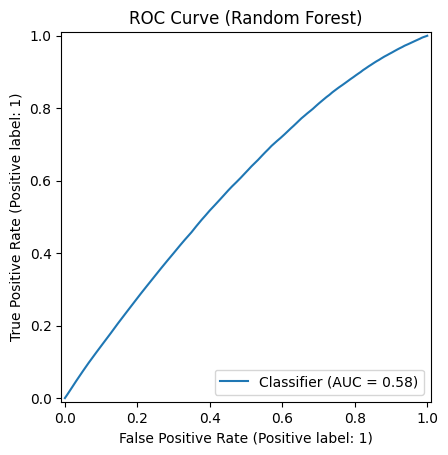

Saved: C:\Users\chank\github\DataScienceProject1\output\roc_curve_random_forest.png


In [13]:
# ROC curve plot
roc_path = OUTPUT_DIR / safe_filename("roc_curve_random_forest.png")
plt.figure()
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC Curve (Random Forest)")
plt.savefig(roc_path, bbox_inches="tight")
plt.show()

print("Saved:", roc_path.resolve())


## Feature importance
Since we’re using only one feature (RT score), its importance will be 1.0. This cell is included for completeness and becomes useful if you add more predictors later.

In [14]:
importances = rf.feature_importances_
imp_df = pd.DataFrame({"feature": X.columns, "importance": importances}).sort_values("importance", ascending=False)
display(imp_df)

imp_path = OUTPUT_DIR / "random_forest_feature_importance.csv"
imp_df.to_csv(imp_path, index=False)
print("Saved:", imp_path.resolve())


,feature,importance
0,tomatoMeter,1.0


Saved: C:\Users\chank\github\DataScienceProject1\output\random_forest_feature_importance.csv


## Next steps (optional upgrades)
If you want a more meaningful model, add controls from the movies table, e.g.:
- genre, runtime, rating
- audienceScore / criticsScore (careful: may be circular)
- year, studio

Then use a preprocessing pipeline (impute + one-hot) and fit RF on the expanded feature set.
